# Wrangle and Analyze Data

## Introduction

This project is part of the course Data Analyst for Enterprise Nanodegree Program by Udacity, chapter 4 on Data Wrangling.<br>
The project aims to check and enhance the data wrangling skills I have after finishing this chapter.<br>

The analysis uses data from WeRateDogs twitter account archive and few other datasources and follows the guidelines given in the course

In [1]:
# Import required modules
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import re
from IPython.display import display
import matplotlib.pyplot as plt

## Gathering Data

The first step in data wrangling is aquiring all data we need in the analysis.<br >
We will gather data from 3 different sources:
- a file containing the WeRateDogs Twitter archive, downloaded by the authors and provided to us by Udacity
- a file containing breed predictions for each dog from the images in the archive, build and provided by Udacity
- additional data about each tweet, fetched using Twitter API

1. Downloading The WeRateDogs Twitter archive

In [2]:
def gather_data(url, local_file):
    response = requests.get(url)
    with open(local_file, mode='wb')  as file:
        file.write(response.content)
    assert os.path.getsize(local_file) > 0, "the file %s is empty" % local_file

tweets_archive_path = 'twitter-archive-enhanced.csv'
gather_data(
    'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv',
    tweets_archive_path
    )

2. Download the tweet image predictions

In [3]:
image_predictions_path = 'image-predictions.tsv'
gather_data(
    'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv',
    image_predictions_path
    )

3. Fetch tweets data using Twitter API

In [4]:
tweet_json_path = 'tweet_json.txt'

In [5]:
#https://developer.twitter.com/en/apps/17200974
# keys must be deleted when sharing this document
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
df_tweets = pd.read_csv(tweets_archive_path)

In [7]:
errors = {}
# download only once
if not os.path.exists(tweet_json_path):
    with open(tweet_json_path, 'a') as the_file:
        counter = 0
        for tweet_id in df_tweets['tweet_id']:
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')

                the_file.write(json.dumps(tweet._json) + "\n")

            except tweepy.TweepError as e:
#                 print('Download failed for %d' % tweet_id)
                errors[tweet_id] = e

            counter +=1

            if counter % 100 == 0:
                print('.', end = '')

if len(errors) > 0:
    twitter_errors_file = 'twitter_download_errors.txt'
    print('There are some downloading errors, check the %s errors file' % twitter_errors_file)
    with open(twitter_errors_file, mode='a') as f:
        for er in errors.items():
            print(er, file=f)

We saved the results and the errors is separate files on the disk.<br>
There were 23 errors during the donwload process, all of them with code: 144 "No status found with that ID."<br>
In the [documentation](https://developer.twitter.com/en/docs/basics/response-codes) we can find this as an explanation: "Corresponds with HTTP 404. The requested Tweet ID is not found (if it existed, it was probably deleted)"<br>
We saved all the data fetched via the API but will use only retweet_count, favorite_count, create_date, tweet_id

## Assessing Data

During the assesment process we will check for two aspects of the gathered data: **quality** and **tidiness**.<br>
The quality refers to the issues we have with the content of the data: inaccurate data, corrupted data or duplicated data.<br>
Tidiness is related to the structure of the data, Tidy data requires:
- each variable forms a column.
- each observation forms a row.
- each type of observational unit forms a table.

### Visual Assesment
By visually inspecting the datasets we can get acquainted with the data and better understand what is it about

In [8]:
tweets = pd.read_csv(tweets_archive_path)
tweets

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [9]:
tweet_details = pd.read_json(tweet_json_path, lines=True)
tweet_details = tweet_details[['id', 'retweet_count', 'favorite_count']].rename(columns={"id": "tweet_id"})
tweet_details

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7842,36781
1,892177421306343426,5805,31674
2,891815181378084864,3845,23855
3,891689557279858688,8010,40110
4,891327558926688256,8652,38312
5,891087950875897856,2885,19275
6,890971913173991426,1899,11229
7,890729181411237888,17507,62023
8,890609185150312448,3976,26514
9,890240255349198849,6813,30356


In [10]:
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


### Programatic Assesment
We dig deeper into the data issues by looking programatically at some aspects of the data

Use info function to list columns names types and missing values

In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
tweet_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
tweet_id          2333 non-null int64
retweet_count     2333 non-null int64
favorite_count    2333 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [13]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Use describe function to look at the numeric columns stats

In [14]:
tweets.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
tweet_details.describe()

,tweet_id,retweet_count,favorite_count
count,2.333000e+03,2333.000000,2333.000000
mean,7.419279e+17,2761.458208,7674.051865
std,6.820607e+16,4673.127291,11912.864790
min,6.660209e+17,1.000000,0.000000
25%,6.782786e+17,555.000000,1333.000000
50%,7.184547e+17,1291.000000,3343.000000
75%,7.986654e+17,3212.000000,9431.000000
max,8.924206e+17,79305.000000,158986.000000


In [16]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


Check distinct tweets sources

In [17]:
tweets.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [18]:
tweets.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [19]:
tweets.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [20]:
tweets.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [21]:
tweets.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

Check rating numerator - should be between 10 and 14

In [22]:
tweets.rating_numerator.value_counts().sort_index(ascending=False)

1776      1
960       1
666       1
420       2
204       1
182       1
165       1
144       1
143       1
121       1
99        1
88        1
84        1
80        1
75        2
60        1
50        1
45        1
44        1
27        1
26        1
24        1
20        1
17        1
15        2
14       54
13      351
12      558
11      464
10      461
9       158
8       102
7        55
6        32
5        37
4        17
3        19
2         9
1         9
0         2
Name: rating_numerator, dtype: int64

Check rating denominator - should be 10

In [23]:
tweets.rating_denominator.value_counts().sort_index(ascending=False)

170       1
150       1
130       1
120       1
110       1
90        1
80        2
70        1
50        3
40        1
20        2
16        1
15        1
11        3
10     2333
7         1
2         1
0         1
Name: rating_denominator, dtype: int64

In [24]:
def print_full(text):
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    display(text)
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

print_full(tweets[(tweets.rating_numerator < 10) | (tweets.rating_numerator > 14)][['rating_numerator', 'rating_denominator', 'text']].sample(100))

,rating_numerator,rating_denominator,text
1555,7,10,This is Hamrick. He's covered in corn flakes. Silly pupper. Looks congested. 7/10 considerably petable https://t.co/ROPZcAMQKI
2020,9,10,This is Tuco. That's the toast that killed his father. 9/10 https://t.co/ujnWy26RMe
1793,9,10,Meet Humphrey. He's a Northern Polyp Viagra. One ear works. Face stuck like that. Always surprised. 9/10 petable af https://t.co/FS7eJQM2F4
2338,1,10,Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX
765,3,10,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M
1646,9,10,Here we see a faulty pupper. Might need to replace batteries. Try turning off &amp; back on again. 9/10 would still pet https://t.co/O1E4AtHVxO
745,8,10,RT @dog_rates: This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.c…
1478,3,10,Meet Phil. He's big af. Currently destroying this nice family home. Completely uncalled for. 3/10 not a good pupper https://t.co/fShNNhBWYx
987,8,10,This is Dietrich. He hops at random. Other doggos don't understand him. It upsets him greatly. 8/10 would comfort https://t.co/U8cSRz8wzC
1559,9,10,This is Frönq. He got caught stealing a waffle. Damn it Frönq. 9/10 https://t.co/7ycWCUrjmZ


The extracted ratings seem to be accurate, maybe check with a regular expression

Check for abnormally long tweets

In [25]:
tweets.text.str.len().max()

167

In [26]:
tweets[tweets['name'].str.istitle() == False]['name'].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'BeBe', 'mad',
       'an', 'very', 'just', 'DonDon', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'CeCe', 'the',
       'by', 'officially', 'life', 'light', 'space', 'JD', 'DayZ'], dtype=object)

There are some names that are not actually names

In [27]:
# tweets[tweets.expanded_urls.str.contains('https://twitter.com/dog_rates/status/') == False]

In [28]:
tweets[tweets.tweet_id.duplicated()].shape[0]

0

In [29]:
tweet_details[tweet_details.tweet_id.duplicated()].shape[0]

0

In [30]:
all_columns = pd.Series(list(tweets) + list(tweet_details) + list(image_predictions))
all_columns[all_columns.duplicated()]

17    tweet_id
20    tweet_id
dtype: object

In [31]:
tweets[tweets.tweet_id == 883482846933004288]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None


In [32]:
tweets[tweets.name == 'None'][['tweet_id', 'text', 'name']]

,tweet_id,text,name
5,891087950875897856,Here we have a majestic great white breaching ...,None
7,890729181411237888,When you watch your owner call another dog a g...,None
12,889665388333682689,Here's a puppo that seems to be on the fence a...,None
24,887343217045368832,You may not have known you needed to see this ...,None
25,887101392804085760,This... is a Jubilant Antarctic House Bear. We...,None
30,886267009285017600,@NonWhiteHat @MayhewMayhem omg hello tanner yo...,None
32,886054160059072513,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,None
35,885518971528720385,I have a new hero and his name is Howard. 14/1...,None
37,885167619883638784,Here we have a corgi undercover as a malamute....,None
41,884441805382717440,"I present to you, Pup in Hat. Pup in Hat is gr...",None


In [33]:
duplicated_tweet_images = image_predictions[image_predictions['jpg_url'].duplicated()].tweet_id

In [34]:
image_predictions[image_predictions['jpg_url'] == 'https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False


### Data dictionary
`tweets` table
- **tweet_id**: the unique identifier for a tweet
- **in_reply_to_status_id**: if the tweet is a reply to another tweet this field will be the original tweet's id
- **in_reply_to_user_id**: if the tweet is a reply to another tweet this field will be the original tweet's user id
- **timestamp**: the timestamp inlcuding date and time of the tweet in string ISO 8601 format
- **source**: the utility used to post the tweet (iPhone|Web Client|Vine|TweetDeck)
- **text**: the actual UTF-8 text of the tweet
- **retweeted_status_id**: if the tweet is a retweet the field be the original tweet's id
- **retweeted_status_user_id**: if the tweet is a retweet the field be the original tweet's user id
- **retweeted_status_timestamp**: if the tweet is a retweet the field be the original tweet's timestamp
- **expanded_urls**: the full url of the tweet (https://twitter.com/{user}/status/{tweet_id}")
- **rating_numerator**: the numerator of the rating given by the authors (usually between 10 and 14)
- **rating_denominator**: the denominator of the raging given by the authors (usually 10)
- **name**: the name of the rated dog (or None if not identified)
- **doggo**, **floofer**, **pupper**, **puppo**: dog category by the authors as described [here](https://video.udacity-data.com/topher/2017/October/59e04ceb_dogtionary-combined/dogtionary-combined.png)

`tweets_details` table
- **tweet_id**: the unique identifier for a tweet
- **retweet_count**: retweet count
- **favorite_count**: likes count

`image_prediction` table
- **tweet_id**: the unique identifier for a tweet
- **jpg_url**: image url
- **img_num**: image number (1 to 4)
- **pX**: breed predicted by algorithm X
- **pX_conf**: confidence level of the algorithm X
- **pX_dog**: whether or not the algorithm X predicted the image is a breed of dog

## Quality
Here I try to identify all issues with the datasets

### Tidiness
- **in_reply_to_status_id**, **retweeted_status_id**: we should remove replies and retweets ✓
- **doggo**, **floofer**, **pupper**, **puppo**: shlould be one categorical column, a small part of the tweets include a category ✓
- tables `tweets` and `tweet_details` should be merged ✓
- **expanded_urls**: have multiple values ✓
- ~~table `tweets` include both `dog` and `tweets` information, maybe separate them~~
- merge all dataframes into one master dataframe  ✓
- build a separate predictions dataframe with one algorithm per line for the analysis ✓

### Quality
- **tweet_id** - convert to strings
- ~~**in_reply_to_status_id**, **in_reply_to_user_id**, **retweeted_status_id**, **retweeted_status_user_id** - are floats, should be string~~
- **timestamp** is a string ✓
- **sources** include an anchor ✓
- ~~**expanded_urls** should start with "https://twitter.com/dog_rates/status/" for ratings made by WeRateDogs~~
- remove tweets with multiple ratings ✓
- **rating_nominator**: some values with decimals are not parsed ok (ex: 883482846933004288) ✓
- **rating_nominator**: should be between 10 and 14, reimport and remove bad ones ✓
- **rating_denominator**: should be 10, remove other values ✓
- **rating_nominator**, **rating_denominator**: some tweets have multiple texts like number/number and the extraction was done using the first match 
- **name**: is "None" instead of NaN ✓
- **name**: some values are words not names, check them and replace with NaN if can't fix ✓
- **doggo**, **floofer**, **pupper**, **puppo**: all contain "None" as the null value ✓
- predicted breeds don't have a standard format
- there are some duplicate images, the images and the corresponding tweets should be deleted

## Cleaning Data

We start the clean process by making a copy of all tables

In [35]:
tweets_clean = tweets.copy()
tweet_details_clean = tweet_details.copy()
image_predictions_clean = image_predictions.copy()

### Remove replies and retweets

#### Define
Convert all **tweet_id** to strings
#### Code

In [36]:
tweets_clean['tweet_id'] = tweet_details_clean['tweet_id'].astype(str)
tweet_details_clean['tweet_id'] = tweet_details_clean['tweet_id'].astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

In [37]:
assert tweets_clean.tweet_id.dtype == 'O'
assert tweet_details_clean.tweet_id.dtype == 'O'
assert image_predictions_clean.tweet_id.dtype == 'O'

#### Define
Keep only tweets that have the fields `in_reply_to_status_id` or `retweeted_status_id` NaN
Then remove the unused columns

#### Code

In [38]:
tweets_clean = tweets_clean[(tweets_clean['in_reply_to_status_id'].isna() == True)  & (tweets_clean['retweeted_status_id'].isna() == True)]

#### Test

In [39]:
assert tweets_clean[tweets_clean['in_reply_to_status_id'].isna() == False].shape[0] == 0

In [40]:
assert  tweets_clean[tweets_clean['in_reply_to_status_id'].isna() == False].shape[0] == 0

In [41]:
tweets_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Define
For columns: **doggo**, **floofer**, **pupper**, **puppo** replace 'None' to NaN and convert to a sigle column named **dog_stage**

#### Code

In [42]:
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']

In [43]:
tweets_clean.replace('None', np.nan, inplace=True)
tweets_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN


In [44]:
tweets_clean[dog_stages].count().sum()

347

In [45]:
tweets_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN


In [46]:
assert tweets_clean[dog_stages].count().sum() == 347

In [47]:
def dog_stage(row):
    
    for stage in dog_stages:
        if pd.notna(row[stage]):
            return stage
    return np.nan

tweets_clean['dog_stage'] = tweets_clean.apply (lambda row: dog_stage(row), axis=1).astype('category')
tweets_clean.drop(dog_stages, axis=1, inplace=True)

#### Test

In [48]:
assert tweets_clean.dog_stage.value_counts().sum() == 336

Some of the tweets could be refering to multiple dogs so they can have multiple dog_stages

In [49]:
introductions = ['This is ', 'Say hello ', 'Meet ']

In [50]:
tweets_clean[tweets_clean.text.str.contains('|'.join(introductions))]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo
10,890006608113172480,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,NaN
11,889880896479866881,2017-07-25 16:11:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruno. He is a service shark. Only get...,https://twitter.com/dog_rates/status/889880896...,13,10,Bruno,NaN


#### Define
Will merge tables `tweets` and `tweet_details`

#### Code

In [51]:
tweets_clean = tweets_clean.merge(tweet_details_clean, how = 'left', on = 'tweet_id')

#### Test

In [52]:
assert (tweets_clean.columns == ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'retweet_count', 'favorite_count']).all()

#### Define
Keep only one value from expanded urls and rename to singular

#### Code

In [53]:
tweets_clean['expanded_urls'] = tweets_clean['expanded_urls'].str.split(',', expand=True)[0]
tweets_clean = tweets_clean.rename(index=str, columns={"expanded_urls": "expanded_url"})

#### Test

In [54]:
assert tweets_clean['expanded_url'].str.contains(',').sum() == 0

In [55]:
assert 'expanded_urls' not in tweets_clean.columns

#### Define
Convert timestamp to datime

#### Code

In [56]:
tweets_clean['timestamp'] = pd.to_datetime(tweets_clean['timestamp'])

#### Test 

In [57]:
assert tweets_clean.timestamp.dtype == 'datetime64[ns]'

#### Define
Remove anchors from sources

#### Code

In [58]:
tweets_clean['source'] = tweets_clean['source'].str.replace(r'<[^>]*>', '', regex=True)

#### Test

In [59]:
assert (tweets_clean['source'].unique() == ['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck']).all()

#### Define
Remove tweets with multiple ratings

#### Code

In [60]:
rating_pattern = '(\d+\.*\d*\/\d+)'

def count_ratings(row):
    return len(re.findall(rating_pattern, row['text']))

tweets_clean['ratings_count'] = tweets_clean.apply(lambda row: count_ratings(row), axis=1)

In [61]:
tweets_clean = tweets_clean.drop( tweets_clean[tweets_clean['ratings_count'] > 1].index)

#### Test

In [62]:
assert tweets_clean[tweets_clean['ratings_count'] > 1].shape[0] == 0

#### Define
Update tweets with badly extracted float rating_numerators

#### Code

In [63]:
ratings = tweets_clean['text'].str.extract('(\d+\.*\d*\/\d+)', expand=False).str

In [64]:
tweets_clean['rating_numerator_fixed'] = ratings.split('/').str[0].astype(float)
tweets_clean['rating_denominator_fixed'] = ratings.split('/').str[1].astype(float)

In [65]:
tweets_clean

,tweet_id,timestamp,source,text,expanded_url,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,ratings_count,rating_numerator_fixed,rating_denominator_fixed
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,7842.0,36781.0,1,13.0,10.0
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,5805.0,31674.0,1,13.0,10.0
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,3845.0,23855.0,1,12.0,10.0
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,8010.0,40110.0,1,13.0,10.0
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,8652.0,38312.0,1,12.0,10.0
5,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,2885.0,19275.0,1,13.0,10.0
6,890971913173991426,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,https://gofundme.com/ydvmve-surgery-for-jax,13,10,Jax,NaN,1899.0,11229.0,1,13.0,10.0
7,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,17507.0,62023.0,1,13.0,10.0
8,890609185150312448,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,3976.0,26514.0,1,13.0,10.0
9,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,6813.0,30356.0,1,14.0,10.0


See the differences

In [66]:
tweets_clean[tweets_clean['rating_numerator_fixed'] != tweets_clean['rating_numerator']]

,tweet_id,timestamp,source,text,expanded_url,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,ratings_count,rating_numerator_fixed,rating_denominator_fixed
41,883360690899218434,2017-07-08 00:28:19,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,NaN,3440.0,21585.0,1,13.50,10.0
528,784183165795655680,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,NaN,8377.0,20803.0,1,9.75,10.0
586,775364825476165632,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,pupper,3074.0,7628.0,1,11.27,10.0
1474,679729593985699840,2015-12-25 21:06:00,Twitter for iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,NaN,NaN,832.0,2181.0,1,11.26,10.0


In [67]:
tweets_clean.drop(['rating_numerator'], axis=1, inplace=True)
tweets_clean = tweets_clean.rename(index=str, columns={"rating_numerator_fixed": "rating_numerator"})

#### Test

In [68]:
assert tweets_clean[tweets_clean['rating_denominator_fixed'] != tweets_clean['rating_denominator']].shape[0] == 0

In [69]:
tweets_clean.drop(['rating_denominator_fixed'], axis=1, inplace=True)

In [70]:
assert (tweets_clean[tweets_clean.tweet_id == 883482846933004288].rating_numerator == 13.5).all()
assert (tweets_clean[tweets_clean.tweet_id == 786709082849828864].rating_numerator == 9.75).all()
assert (tweets_clean[tweets_clean.tweet_id == 778027034220126208].rating_numerator == 11.27).all()
assert (tweets_clean[tweets_clean.tweet_id == 680494726643068929].rating_numerator == 11.26).all()

#### Define
Remove tweets with denominators different than 10

#### Code

In [71]:
removed_tweets_count = tweets_clean[tweets_clean['rating_denominator'] != 10].shape[0]
# remove tweets if below a threshhold
assert removed_tweets_count < 30

In [72]:
tweets_clean = tweets_clean.drop( tweets_clean[tweets_clean['rating_denominator'] != 10].index)

#### Test

In [73]:
assert tweets_clean[tweets_clean['rating_denominator'] != 10].shape[0] == 0

#### Define
Some dogs names are just random words extracted from the tweet

#### Code

In [74]:
bad_dog_names = ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad',
       'an', 'very', 'just', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'the',
       'by', 'officially', 'life', 'light', 'space' ]

In [75]:
print_full(tweets_clean[tweets_clean['name'].isin(bad_dog_names)].text)

21      I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba                              
51      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF       
141     We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9              
156     Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
263     There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  \nhttps://t.co/dp5h9bCwU7                                                          
289     Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK                                 

By looking manually at the 100 rows we can see that the tweets don't have the dog name, so we will replace it with NaN

In [76]:
tweets_clean.name.replace(to_replace=bad_dog_names, value=np.full([len(bad_dog_names)], np.nan), inplace=True)

#### Test

In [77]:
assert tweets_clean[tweets_clean['name'].isin(bad_dog_names)].shape[0] == 0

#### Define
Try to extract some of the names from the text

#### Code

In [78]:
name_regex = '([A-Z]{1}[a-zA-Z]*)'
name_patterns = [
    'This is ' + name_regex, 
    'That is ' + name_regex, 
    'Meet ' + name_regex,
    'Her name is ' + name_regex,
     ' named ' +  name_regex + '\.',
]

In [79]:
results_count = 0
for pat in name_patterns:
    results_count += tweets_clean[tweets_clean.name.isna()].text.str.extract(pat).count()
print(results_count)

0    26
dtype: int64


There are very few results, probably the patterns are not ok enough

#### Define
There are 66 duplicated images, we will delete the images and the corresponding tweets

#### Code

In [80]:
duplicated_images = image_predictions_clean['jpg_url'].duplicated()
duplicated_tweets_images = image_predictions_clean[duplicated_images].tweet_id

In [81]:
image_predictions_clean.drop(image_predictions_clean[duplicated_images].index, inplace=True)

In [82]:
tweets_clean.drop(tweets_clean[tweets_clean.tweet_id.isin(duplicated_tweets_images)].index, inplace=True)

### Test

In [83]:
assert image_predictions_clean[duplicated_images].shape[0] == 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [84]:
assert tweets_clean[tweets_clean.tweet_id.isin(duplicated_tweets_images)].shape[0] == 0

#### Define
Dog images predictions are split in 3 sets of columns. Will make them one per line

#### Code

In [85]:
image_predictions_long = image_predictions_clean.copy()

In [86]:
image_predictions_long = image_predictions_long.rename(columns={
    'p1': 'breed_1', 'p1_conf': 'confidence_1', 'p1_dog': 'is_dog_1',
    'p2': 'breed_2', 'p2_conf': 'confidence_2', 'p2_dog': 'is_dog_2',
    'p3': 'breed_3', 'p3_conf': 'confidence_3', 'p3_dog': 'is_dog_3'
})
image_predictions_long

,tweet_id,jpg_url,img_num,breed_1,confidence_1,is_dog_1,breed_2,confidence_2,is_dog_2,breed_3,confidence_3,is_dog_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [87]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html
image_predictions_long = pd.wide_to_long(image_predictions_long, 
                                          ['breed', 'confidence', 'is_dog'], 
                                          i='tweet_id', j='prediction_number', sep='_')

In [88]:
image_predictions_long = image_predictions_long.reset_index()

### Test

In [89]:
assert image_predictions_long.shape[0] / image_predictions_clean.shape[0] == 3

#### Define
Dog images predictions breeds don't have a standerd format. Will make all lowecase with underscores

#### Code

In [90]:
image_predictions_long.breed = image_predictions_long.breed.str.lower()

#### Test

In [91]:
assert (image_predictions_long.breed.str.islower() == False).sum() == 0

#### Define
Merge image predictions with tweets table

#### Code

In [92]:
tweets_clean = tweets_clean.merge(image_predictions_clean, how = 'left', on = 'tweet_id')

#### Define
**retweet_count**, **favorite_count** should be integers

#### Code

In [93]:
tweets_clean['retweet_count'] = tweets_clean['retweet_count'].fillna(0).astype(int)

In [94]:
tweets_clean['favorite_count'] = tweets_clean['favorite_count'].fillna(0).astype(int)

#### Test

In [95]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2014 entries, 0 to 2013
Data columns (total 23 columns):
tweet_id              1992 non-null object
timestamp             2014 non-null datetime64[ns]
source                2014 non-null object
text                  2014 non-null object
expanded_url          2011 non-null object
rating_denominator    2014 non-null int64
name                  1344 non-null object
dog_stage             324 non-null category
retweet_count         2014 non-null int64
favorite_count        2014 non-null int64
ratings_count         2014 non-null int64
rating_numerator      2014 non-null float64
jpg_url               1769 non-null object
img_num               1769 non-null float64
p1                    1769 non-null object
p1_conf               1769 non-null float64
p1_dog                1769 non-null object
p2                    1769 non-null object
p2_conf               1769 non-null float64
p2_dog                1769 non-null object
p3                    17

## Storing and Acting on Wrangled Data

We will store the cleaned datasets to different files.

In [96]:
tweets_clean.to_csv('tweets_clean.csv', index=False)
image_predictions_long.to_csv('image_predictions_long.csv', index=False)

As requested we will store a `twitter_archive_master.csv` file

In [97]:
tweets_clean.to_csv('twitter_archive_master.csv', index=False)

## Analysis

Using the cleaned datasets we will try to respond to few questions:
- What are the most predicted dog breeds
- Most rated types of dogs
- Average likes and retweets per category
- Top liked dogs per category

In [98]:
breeds = image_predictions_long[image_predictions_long.is_dog].breed
breeds_percent = breeds.value_counts()/breeds.count()

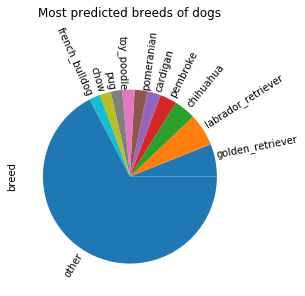

In [99]:
pie_threshold = 0.02
significant_breeds = breeds_percent[breeds_percent >= pie_threshold]
other_breeds = breeds_percent[breeds_percent < pie_threshold]
significant_breeds['other'] = other_breeds.sum()

ax = significant_breeds.plot(kind='pie', rotatelabels=True, labeldistance=1)
ax.set(aspect="equal", title='Most predicted breeds of dogs\n\n\n');

The breeds: golden retriever, labrador retriever and chihuaua are in the top 3 most predicted breeds of dogs

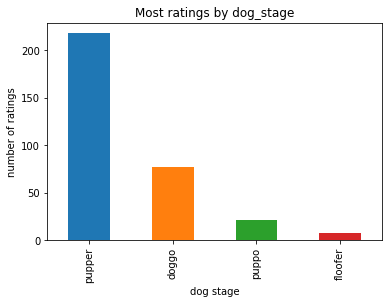

In [100]:
ax = tweets_clean.dog_stage.value_counts().plot(kind='bar', title = 'Most ratings by dog_stage')
ax.set_ylabel('number of ratings')
ax.set_xlabel('dog stage');

Most ratings are for 'puppers'

In [101]:
dog_stage_means = tweets_clean.groupby('dog_stage').mean()

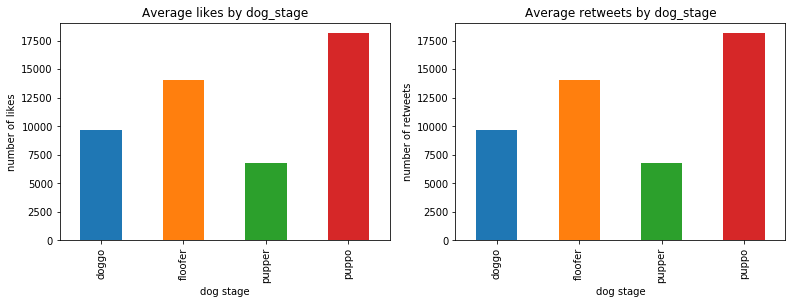

In [109]:
fig = plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)

ax1 = dog_stage_means.favorite_count.plot(kind='bar', title = 'Average likes by dog_stage')
ax1.set_ylabel('number of likes')
ax1.set_xlabel('dog stage');

plt.subplot(1, 2, 2)
ax2 = dog_stage_means.favorite_count.plot(kind='bar', title = 'Average retweets by dog_stage')
ax2.set_ylabel('number of retweets')
ax2.set_xlabel('dog stage');

In [103]:
most_liked = tweets_clean.groupby('dog_stage').max()['favorite_count'].sort_values(ascending=False).reset_index()

In [104]:
print('Most liked dogs by dog_stage')
display(pd.DataFrame(most_liked))

Most liked dogs by dog_stage


,dog_stage,favorite_count
0,puppo,118230
1,pupper,117370
2,floofer,50812
3,doggo,32938


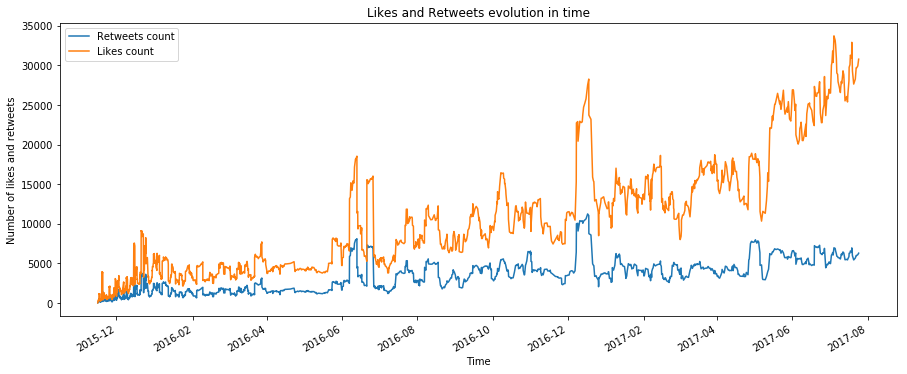

In [105]:
tweets_by_time = tweets_clean.copy().set_index('timestamp')
tweets_by_time = tweets_by_time[['retweet_count', 'favorite_count']].rolling(window=15).mean()
ax = tweets_by_time[['retweet_count', 'favorite_count']].plot(figsize=(15,6), title="Likes and Retweets evolution in time")
ax.legend(["Retweets count", "Likes count"])
ax.set_ylabel('Number of likes and retweets')
ax.set_xlabel('Time');

Even thow the account seems to be a joke, the community arount it seems to be very engaged, retweets counts and likes are constantly incereasing

## Report

See `act_report_.pdf` and `wrangle_act.pdf`